# USAID Sentiment Analysis

## Importing Libraries

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

import re

import string
from string import punctuation
from textblob import TextBlob

from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perpe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Staging

In [3]:
df = pd.read_csv("usaid_reddit_posts_New.csv", encoding='latin1')
df.head()

,Post ID,region,Text,title,Author,subreddit,score,Upvote Ratio,Number of Comments,Created At,url,Created Timestamp,comments,Unnamed: 13
0,1iis138,Africa,NaN,The Real Reason Musk is After USAID: They Help...,shake1010,MarchAgainstNazis,860,0.99,21,1738808995,https://i.redd.it/arjpjejvjfhe1.jpeg,2/6/2025 2:29,Welcome to /r/MarchAgainstNazis! \n\n**Please...,NaN
1,1iiontm,Africa,NaN,Usaid Delivering Foreign Aid to starving child...,trailer8k,Trailerclub,1,1,0,1738799255,https://v.redd.it/w5xmfqsvqehe1,2/5/2025 23:47,NaN,NaN
2,1iinl7c,Africa,How USAid has been spending taxpayer money\n\n...,How has USAID been spending taxpayer money?,ProtectedHologram,conspiracy,38,0.75,33,1738796394,https://www.reddit.com/r/conspiracy/comments/1...,2/5/2025 22:59,###[Meta] Sticky Comment\n\n[Rule 2](https://w...,NaN
3,1iini2u,Africa,NaN,Here's my list of exposed corrupt money launde...,Believe_143,LibTears,183,0.99,23,1738796165,https://i.redd.it/qt4m216qhehe1.jpeg,2/5/2025 22:56,And yet...hurricane victims in NC and fire vic...,NaN
4,1iijyzc,Africa,Source: https://x.com/kenklippenstein/status/1...,Some people say that USAIDâs aid is exclusiv...,SnooAdvice725,Lebanese,123,0.98,12,1738787376,https://i.redd.it/esuop84lrdhe1.jpeg,2/5/2025 20:29,So they're interfering in international politi...,NaN


## Data Understanding

In [4]:
# Merge the 'Text', 'title', and 'comments' columns into a new column called 'merged text'
df['merged text'] = df[['Text', 'title', 'comments']].apply(lambda x: ' '.join(x.dropna()), axis=1)

In [5]:
df.shape

(1299, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Post ID             1299 non-null   object
 1   region              1299 non-null   object
 2   Text                1018 non-null   object
 3   title               1298 non-null   object
 4   Author              1298 non-null   object
 5   subreddit           1298 non-null   object
 6   score               1298 non-null   object
 7   Upvote Ratio        1298 non-null   object
 8   Number of Comments  1298 non-null   object
 9   Created At          1298 non-null   object
 10  url                 1298 non-null   object
 11  Created Timestamp   1297 non-null   object
 12  comments            800 non-null    object
 13  Unnamed: 13         1 non-null      object
 14  merged text         1299 non-null   object
dtypes: object(15)
memory usage: 152.4+ KB


In [7]:
df.columns

Index(['Post ID', 'region', 'Text', 'title', 'Author', 'subreddit', 'score',
       'Upvote Ratio', 'Number of Comments', 'Created At', 'url',
       'Created Timestamp', 'comments', 'Unnamed: 13', 'merged text'],
      dtype='object')

In [8]:
df = df.drop(columns = ['Post ID', 'Text', 'title', 'Author', 'subreddit', 'score',
'Created At', 'url','Created Timestamp', 'comments', 'Unnamed: 13'])
df.head()

,region,Upvote Ratio,Number of Comments,merged text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...


In [9]:
df.isnull().sum()

region                0
Upvote Ratio          1
Number of Comments    1
merged text           0
dtype: int64

In [10]:
df = df.dropna()
df.isnull().sum(), df.shape

(region                0
 Upvote Ratio          0
 Number of Comments    0
 merged text           0
 dtype: int64,
 (1298, 4))

In [11]:
df.duplicated().sum()

14

In [12]:
# Identify and display duplicated rows
duplicated_rows = df[df.duplicated()]
duplicated_rows.head()

,region,Upvote Ratio,Number of Comments,merged text
52,Africa,1,0,[Politics] - How Donald Trump's USAID pause th...
54,Africa,1,0,[Politics] - How Donald Trump's USAID pause th...
243,Middle East,1,0,"Trump proposes taking over the Gaza strip, bui..."
248,Middle East,1,0,"Trump proposes taking over the Gaza strip, bui..."
249,Middle East,1,0,"Trump proposes taking over the Gaza strip, bui..."


In [13]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [14]:
df.shape

(1284, 4)

## Sentiment Preprocessing

### Removing Tags

In [16]:
def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile('<.*?>'), '', str(raw_text))
    return cleaned_text

In [17]:
df['cleaned_text'] = df['merged text'].apply(remove_tags)

In [18]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,The Real Reason Musk is After USAID: They Help...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,Usaid Delivering Foreign Aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,How USAid has been spending taxpayer money\n\n...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,Here's my list of exposed corrupt money launde...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,Source: https://x.com/kenklippenstein/status/1...


### Removing URLS

In [19]:
def remove_urls(text):
    pattern = re.compile(r'https?://\S+|www\.\S+|http?://\S+')
    return pattern.sub(r'', text)

In [20]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_urls)

In [21]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,The Real Reason Musk is After USAID: They Help...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,Usaid Delivering Foreign Aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,How USAid has been spending taxpayer money\n\n...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,Here's my list of exposed corrupt money launde...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,Source: Some people say that USAIDâs aid is...


### Removing Unecessary Characters

In [22]:
def remove_unnecessary_characters(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = re.sub(r'\s+', ' ', str(text)).strip()
    return text

In [23]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_unnecessary_characters)

In [24]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,The Real Reason Musk is After USAID They Helpe...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,Usaid Delivering Foreign Aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,How USAid has been spending taxpayer money 79 ...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,Heres my list of exposed corrupt money launder...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,Source Some people say that USAIDs aid is excl...


### Making all the Text in Lower case

In [25]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x:str(x).lower())

In [26]:
df.head(3)


,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,the real reason musk is after usaid they helpe...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,how usaid has been spending taxpayer money 79 ...


In [27]:
exclude = string.punctuation
exclude

def remove_punc1(text):
    return text.translate(str.maketrans('', '', exclude))

In [28]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_punc1)

In [29]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,the real reason musk is after usaid they helpe...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid to starving child...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,how usaid has been spending taxpayer money 79 ...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,heres my list of exposed corrupt money launder...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,source some people say that usaids aid is excl...


### Removing Stepwords From Dataset

In [31]:
sw_list = stopwords.words('english')

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))

In [32]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,real reason musk usaid helped end apartheid so...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid starving children...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,usaid spending taxpayer money 79 million teach...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,heres list exposed corrupt money laundering fu...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,source people say usaids aid exclusively human...


### Normalizing the Dataset

In [33]:
def normalize_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
    else:
        text = str(text)
    return text
df['cleaned_text'] = df['cleaned_text'].apply(normalize_text)

In [35]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,real reason musk usaid helped end apartheid so...
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid starving children...
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,usaid spending taxpayer money 79 million teach...
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,heres list exposed corrupt money laundering fu...
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,source people say usaids aid exclusively human...


### Sentence Polarity

In [37]:
def checkPostiveOrNegativeSentence(sentence):
    text = sentence.strip().lower()
    sentiment = TextBlob(text).sentiment
    if sentiment.polarity > 0:
        return "Positive 😊"
    elif sentiment.polarity < 0:
        return "Negative 😠"
    else:
        return "Neutral 😐"

In [38]:
df['Sentiment'] = df['cleaned_text'].apply(checkPostiveOrNegativeSentence)

In [39]:
df.head()

,region,Upvote Ratio,Number of Comments,merged text,cleaned_text,Sentiment
0,Africa,0.99,21,The Real Reason Musk is After USAID: They Help...,real reason musk usaid helped end apartheid so...,Positive 😊
1,Africa,1,0,Usaid Delivering Foreign Aid to starving child...,usaid delivering foreign aid starving children...,Negative 😠
2,Africa,0.75,33,How USAid has been spending taxpayer money\n\n...,usaid spending taxpayer money 79 million teach...,Positive 😊
3,Africa,0.99,23,Here's my list of exposed corrupt money launde...,heres list exposed corrupt money laundering fu...,Negative 😠
4,Africa,0.98,12,Source: https://x.com/kenklippenstein/status/1...,source people say usaids aid exclusively human...,Positive 😊


In [41]:
df.shape

(1284, 6)

## EDA

Class distribution:
Sentiment
Positive 😊    998
Negative 😠    187
Neutral 😐      99
Name: count, dtype: int64

Text length stats:
count     1284.000000
mean      4155.781153
std       5483.444872
min          0.000000
25%        456.750000
50%       1776.500000
75%       5162.250000
max      41026.000000
Name: text_length, dtype: float64


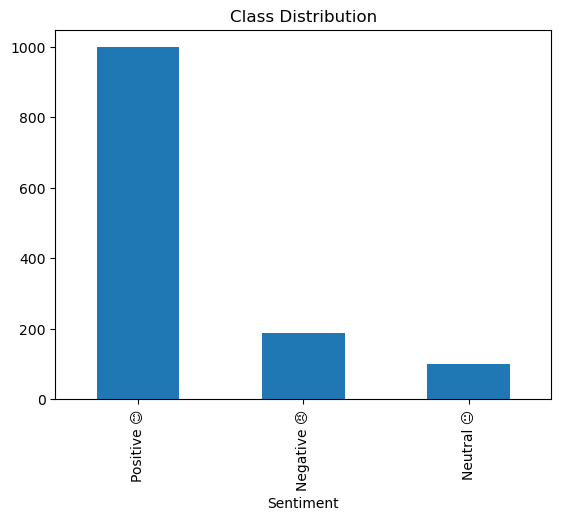

In [46]:
# Perform Exploratory Data Analysis (EDA)
def perform_eda(data):
    # Check class distribution
    print("Class distribution:")
    print(df['Sentiment'].value_counts())

    # Text length analysis
    df['text_length'] = df['cleaned_text'].apply(len)
    print("\nText length stats:")
    print(df['text_length'].describe())

    # Visualize class distribution
    df['Sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
    plt.show()
perform_eda(df)